# Vitrine du projet Euler

## Settings

In [1]:
#pour colab, sinon changer le chemin "/content" ou supprimer ce test
import os
if os.path.exists("/content"):
    !git init
    !git pull https://github.com/vincentvigon/RECHERCHE.git
    %ls
else:
    print("on n'est pas sur colab")

on n'est pas sur colab


In [2]:
from Euler.initial_conditions import GenParam,FuncGenerator
import Euler.core_solver as core
from Euler.backend import K
from Euler.param import Param,Projecter
import matplotlib.pyplot as plt

## Analyse numérique


### Les paramètres globaux

Pour toute la partie analyse numérique:
On travaille avec tensorflow  en 32 bit.
D'après les tests, c'est le plus rapide.

In [3]:
k=K("tf",32)

Tous les paramètres globaux sont dans l'objet suivants

In [4]:
param=Param()
print("Boundary condition",param.BC_solver)
print("Nombre de points d'espace",param.nx)
print("Interval de travail:",param.xmin,"->",param.xmax)
print("Rapport dt/dx:",param.dt_over_dx)

Param initialised with, nx=2000, nx_coarse=199, batch_size=25
Boundary condition periodic
Nombre de points d'espace 2000
Interval de travail: 0 -> 1
Rapport dt/dx: 0.1


In [5]:
genParam=GenParam(param,GenParam.kind_loop)
generator=FuncGenerator(genParam,param,k)



### Données initiales

La génération de fonction est passée sur
des séries de Fourier auquel on ajoute des
discontinuités parcimonieuses, dont la hauteur
est de l'ordre de grandeur que la composante continue.

(25, 2000)


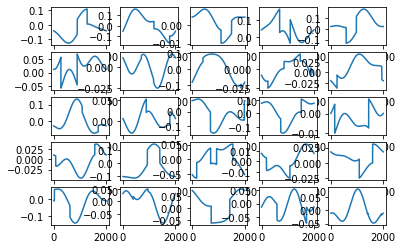

In [6]:
def test_generate_func():

    res=generator.generate_func()
    print(res.shape)

    fig, axs = plt.subplots(5, 5)
    axs = axs.flatten()

    for i in range(25):
        axs[i].plot(res[i,:])

    plt.show()

test_generate_func()


Une donnée `W`, c'est un batch de triplet $\rho,\rho V,E$

In [8]:
W = generator.init_W()
W.shape

TensorShape([25, 2000, 3])

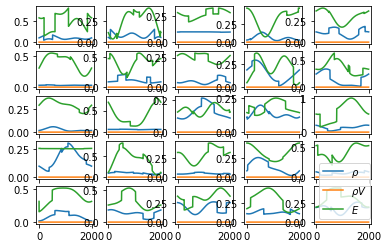

In [9]:
fig,axs=plt.subplots(5,5,sharex="all")
axs=axs.flatten()

for i in range(25):
    axs[i].plot(W[i,:,0],label=r"$\rho$")
    axs[i].plot(W[i,:,1],label=r"$\rho V$")
    axs[i].plot(W[i,:,2],label="$E$")
plt.legend()
plt.show()


### Variations sur les données

L'objet `Var_burger(W)` contient tous les fonctions construites à partir d'une
donnée `W` que l'on a préalablement paddé.
Par exemple
* $\rho V^2$
* $p$ la pression
* La vittesse du sond
* le Flux

On peut récupérer les versions
"décallées" à gauche ou à droite de toutes ces fonctions avec la méthode `get`

In [10]:
var =core.Var_burger(W,param,k)
rhoVV_L=var.get("rhoVV","L")
#de taille nx+1
print(rhoVV_L.shape)
#de taille nx+2
flux=var.get_Flux()
print(flux.shape)
#de taille nx

(25, 2001)
(25, 2002, 3)


La méthode `get_augmentation()` renvoie une gros paquet de fonctions
qui seront fournis aux réseaux de neurone pour qu'il crée sont propre
flux numérique.

In [11]:
augmentation=var.get_augmentation()
print(augmentation.shape)

(25, 2000, 8)


### Flux numérqie HLL

Le flux numérique HLL est le flux numérique de référence. C'est à partir
d'une variation de ce flux qu'on va essayer d'en créer un meilleurs.

In [12]:
flux_num=core.Flux_HLL(var,param,k)
print(flux_num.shape)

(25, 2001, 3)


In [13]:
### Faisons tourner le solver:

In [14]:
res = []
W_init=generator.init_W()
W=W_init#inutile de faire une copie, elle est faites dans le Var_burger() au moment du padding
for t in range(10):
    res.append(W)
    var = core.Var_burger(W, param, k)
    Fnum = core.Flux_HLL(var, param,k)
    W= W - param.dt_over_dx * (Fnum[:, 1:, :] - Fnum[:, :-1, :])
res=k.stack(res)

print(res.shape)

(10, 25, 2000, 3)


Cette boucle est aussi implémentée dans la fonction

    core.compute_solutions(param, nb_t, W_init, is_coarse, k:K)

In [15]:
is_coarse=False
res=core.compute_solutions(param, 10, W_init, is_coarse, k)
print(res.shape)

(10, 25, 2000, 3)


Idem en résolution `coarse`

In [16]:
is_coarse=True
W_init_coarse=Projecter(param.nx_ratio,32).projection(W_init)
res=core.compute_solutions(param, 10, W_init_coarse, is_coarse, k)
print(res.shape)

(10, 25, 199, 3)


### Comparaison des résolutions coarse et fine

On va faire tourner tout ce qu'on a vu avant, avec le K-test Sod.

Param initialised with, nx=6000, nx_coarse=599, batch_size=2


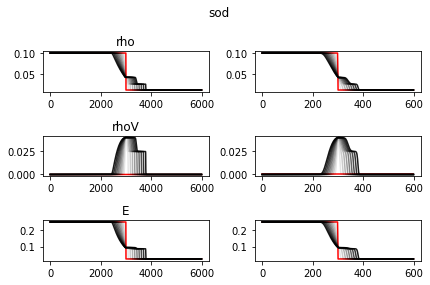

In [17]:
core.compare_with_projection_one_kind(GenParam.kind_sod)

Param initialised with, nx=6000, nx_coarse=599, batch_size=2


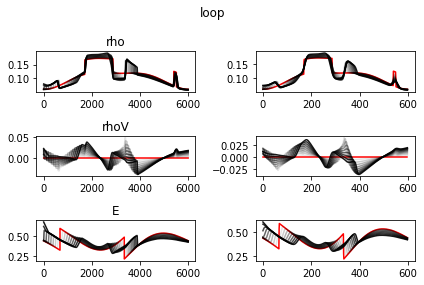

In [18]:
core.compare_with_projection_one_kind(GenParam.kind_loop)

Param initialised with, nx=6000, nx_coarse=599, batch_size=2


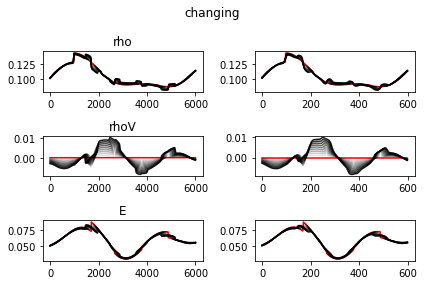

In [19]:
core.compare_with_projection_one_kind(GenParam.kind_changing)


On observe la diffusion numérique sur le maillage coarse.
